In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import networkx as nx
import disambiguation.processing as dp
import disambiguation.linkage as dl
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.min_rows', 1000)
pd.set_option('display.max_columns', 40)

In [16]:
match = pd.read_csv("../data/matches.csv")

## Preprocessing
- Data is currently too large to apply algorithms on
- Split into df, each df bounded by anchors
- Apply algorithms on sub dfs which require disambiguation (because some dfs not have multiple matches)
- Combine after

In [5]:
match['anchor'] = match.apply(lambda row: 1 if row.confidence_score == 1 else None, axis=1)

In [6]:
sum(match['anchor'].notnull())

48716

In [6]:
# create a df with an id ('group') for each anchor
sub_group = pd.DataFrame({'index': list(match.loc[match.anchor.notnull(), :].index), 'group': range(0, sum(match['anchor'].notnull()))}).set_index('index')
sub_group.head()

,group
index,
9,0
10,1
13,2
15,3
16,4


In [7]:
# join it back and fill down
match = match.join(sub_group)

In [8]:
match['group'] = match['group'].fillna(method='ffill').fillna(method='backfill')

In [9]:
# split df into multiple df, each bounded by anchor
sub_group_dict = {group: df for group, df in match.groupby('group')}

In [10]:
# add bottom anchor back
for i in range(0, len(sub_group_dict) - 1):
    sub_group_dict[i] = pd.concat([sub_group_dict[i], sub_group_dict[i+1][0:1]])

In [11]:
# create list of dataframes keys where spatial disambiguation needs to creates weights
sub_group_algos = [i for i in range(0, len(sub_group_dict) - 1) if sum(sub_group_dict[i].census_count > 1) > 0]

In [12]:
print(len(sub_group_dict))
print(len(sub_group_algos))

48716
3687


## Apply Algorithms
- First pass, minimal tuning
- Results will serve as benchmark for further tuning

In [13]:
error = []

# iteratively apply algorithms onto each sub df
for i in sub_group_algos:
    
    try:
        # save df and wrangle to necessary format
        df = sub_group_dict[i]
        path_df = dp.create_path_df(df)

        # apply density clustering and remove outlier nodes
        filtered = dl.apply_density_clustering(path_df)

        # create graph and k shortest paths centrality
        g = dp.create_path_graph(filtered)
        output = dl.apply_k_betweenness(filtered, g)['df']

        sub_group_dict[i] = output
    
    except:
        error.append(i)

In [18]:
len(error)

0

In [19]:
# treatment for rows which were not involved in spatial disambiguation
# anchor: NaN fill 0
# key: 0
# in_cluster: NaN
# spatial weight: confidence weight + 1
sub_group_dict[5918]

,CD_ID,CENSUS_ID,LONG,LAT,confidence_score,MATCH_ADDR,anchor,node_ID,letter,in_cluster,key,spatial_weight
0,CD_10691,CENSUS_162526,-73.984600,40.712312,1.00,"190 MONROE ST, New York, NY",1,N0_0,N0,0,0,2.00
1,CD_56128,CENSUS_162536,-73.984600,40.712312,0.97,"190 MONROE ST, New York, NY",0,N1_0,N1,0,0,1.97
2,CD_102471,CENSUS_162546,-73.984600,40.712312,0.99,"190 MONROE ST, New York, NY",0,N2_0,N2,0,0,1.99
3,CD_137980,CENSUS_162552,-73.984672,40.712304,0.80,"188 MONROE ST, New York, NY",0,N3_0,N3,0,0,0.80
4,CD_137978,CENSUS_162552,-73.983897,40.711899,0.80,"372 CHERRY ST, New York, NY",0,N3_1,N3,0,0,1.80
5,CD_82866,CENSUS_162560,-73.984672,40.712304,0.97,"188 MONROE ST, New York, NY",0,N4_0,N4,0,0,1.97
6,CD_66597,CENSUS_162566,-73.984672,40.712304,0.96,"188 MONROE ST, New York, NY",0,N5_0,N5,0,0,1.96
7,CD_107671,CENSUS_162574,-73.984672,40.712304,0.97,"188 MONROE ST, New York, NY",0,N6_0,N6,0,0,1.97
8,CD_201993,CENSUS_162578,-73.984600,40.712312,0.74,"190 MONROE ST, New York, NY",0,N7_0,N7,0,0,0.74
9,CD_201973,CENSUS_162578,-73.983609,40.712074,0.74,"60 GOUVERNEUR ST, New York, NY",0,N7_1,N7,0,0,1.74


In [20]:
sub_grp_list = [v for k,v in sub_group_dict.items()] 
final = pd.concat(sub_grp_list)

In [21]:
final_processed = final.loc[:, ['CD_ID', 'CENSUS_ID', 'anchor', 'confidence_score', 'in_cluster', 'spatial_weight']]

In [22]:
len(final_processed)

186957

In [23]:
# there will be duplicate rows- remove these
final_processed = final_processed.drop_duplicates(['CD_ID', 'CENSUS_ID'])

In [26]:
final_processed['anchor'] = final_processed['anchor'].fillna(0)

In [27]:
final_processed['spatial_weight'] = final_processed.apply(lambda row: row.confidence_score + 1 if pd.isna(row.spatial_weight) else row.spatial_weight, axis=1)

In [25]:
len(final_processed)

138242

In [28]:
final_processed.to_csv('../data/matches_w_weights.csv')

**Bipartite Matching**
- process up to here is quite expensive, save output
- bipartite matching has to act on subgraphs, else will be too expensive

In [37]:
final_processed = pd.read_csv("../data/matches_w_weights.csv")

In [38]:
b_edges = [(row['CD_ID'], row['CENSUS_ID'], row['spatial_weight']) for index, row in final_processed.iterrows()]
b = nx.Graph()
b.add_weighted_edges_from(b_edges)

In [39]:
subgraphs = list(nx.connected_component_subgraphs(b))

In [44]:
sorted(list(subgraphs[0].nodes))

['CD_74371', 'CENSUS_1537', 'CENSUS_172', 'CENSUS_3399', 'CENSUS_3783']

In [45]:
for i in range(0, len(subgraphs)):
    nodes = sorted(list(subgraphs[i].nodes))
    for node in nodes:
        if node[:2] == 'CD':
            final_processed.at[final_processed.CD_ID == node, 'graph_ID'] = i

In [42]:
len(subgraphs)

102185

In [128]:
matches = [list(nx.max_weight_matching(graph, maxcardinality = True)) for graph in subgraphs]

In [129]:
matches = [sorted(list(item)) for sublist in matches for item in sublist]

In [130]:
len(matches)

104010

In [131]:
matches = pd.DataFrame(matches, columns=['CD_ID', 'CENSUS_ID'])

In [132]:
matches['selected'] = 1

In [68]:
final_processed.head()

,Unnamed: 0,CD_ID,CENSUS_ID,anchor,confidence_score,in_cluster,spatial_weight,graph_ID
0,0,CD_74371,CENSUS_172,0.0,0.85,NaN,1.85,0.0
1,1,CD_24242,CENSUS_306,0.0,0.66,NaN,1.66,1.0
2,2,CD_80330,CENSUS_317,0.0,0.87,NaN,1.87,2.0
3,3,CD_185397,CENSUS_359,0.0,0.96,NaN,1.96,3.0
4,4,CD_137772,CENSUS_361,0.0,0.86,NaN,1.86,4.0


In [54]:
final_processed = final_processed.merge(matches, how='left', on=['CD_ID', 'CENSUS_ID'], validate='one_to_one')
final_processed['selected'] = final_processed['selected'].fillna(0)

NameError: name 'matches' is not defined

In [135]:
sum(final_processed.selected.values)

104010.0

In [136]:
final_processed.to_csv("../data/matches_disambiguated.csv")

In [90]:
# everything above is equivalent to: 
"""
final_processed = pd.read_csv("../data/matches_w_weights.csv")
final_matched = dl.get_matches(final_processed)
final_matched['results'].to_csv("../data/matches_disambiguated.csv")
"""

'\nfinal_processed = pd.read_csv("../data/matches_w_weights.csv")\nfinal_matched = dl.get_matches(final_processed)\nfinal_matched[\'results\'].to_csv("../data/matches_disambiguated.csv")\n'

## Performance
Some metrics to consider:
- how many matches retrieved
- accuracy of the matches
- some way to check false positive/false negative rate?

In [84]:
final_df = pd.read_csv("../data/matches_disambiguated.csv")

In [86]:
# add census lat lng
census_latlng = pd.read_csv("../data/census_1880_mn_v04.csv")
census_latlng['CENSUS_ID'] = 'CENSUS_' + census_latlng['OBJECTID.x'].astype(str)
census_latlng = census_latlng.loc[:, ['CENSUS_ID', 'CENSUS_X', 'CENSUS_Y']]

C:\Users\jolen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [87]:
final_df = final_df.merge(census_latlng, how='left', on='CENSUS_ID', validate='many_to_one')

In [88]:
final_df.head()

,Unnamed: 0,CD_ID,CENSUS_ID,anchor,confidence_score,in_cluster,spatial_weight,graph_ID,selected,CENSUS_X,CENSUS_Y
0,0,CD_74371,CENSUS_172,0.0,0.85,NaN,1.85,0.0,0.0,-74.016583,40.690589
1,1,CD_24242,CENSUS_306,0.0,0.66,NaN,1.66,1.0,0.0,-74.017143,40.690997
2,2,CD_80330,CENSUS_317,0.0,0.87,NaN,1.87,2.0,0.0,-74.015246,40.689766
3,3,CD_185397,CENSUS_359,0.0,0.96,NaN,1.96,3.0,1.0,-74.015246,40.689766
4,4,CD_137772,CENSUS_361,0.0,0.86,NaN,1.86,4.0,0.0,-74.015246,40.689766


In [89]:
# there is one outlier, fix it
print(final_df.loc[final_df.CENSUS_Y > 1000])
final_df.loc[final_df.CENSUS_Y > 1000, 'CENSUS_Y'] = 40.799935
print(final_df.loc[final_df.CENSUS_Y > 1000])

        Unnamed: 0      CD_ID       CENSUS_ID  anchor  confidence_score  \
135669      135669  CD_117484  CENSUS_1092865     1.0               1.0   

        in_cluster  spatial_weight  graph_ID  selected   CENSUS_X  CENSUS_Y  
135669         NaN             2.0  100200.0       1.0 -73.938883   14824.0  
Empty DataFrame
Columns: [Unnamed: 0, CD_ID, CENSUS_ID, anchor, confidence_score, in_cluster, spatial_weight, graph_ID, selected, CENSUS_X, CENSUS_Y]
Index: []


In [93]:
# add streets back
final_df = final_df.merge(match.loc[:, ~match.columns.str.contains('^Unnamed')], how='inner', on = ['CD_ID', 'CENSUS_ID'], validate='one_to_one')

In [96]:
# save for viz
final_df.loc[:, ~final_df.columns.str.contains('^Unnamed')].to_csv("matching_viz/data/matched_viz.csv")

### How many matches retrieved
- as a proportion of CD records (since that's the max no. of matches)

In [33]:
sum(final_df.selected.values) / len(final_df.CD_ID.unique())

0.9897136767182727

### Accuracy

**Using address**

In [99]:
# extract the first part of the street (without manhattan etc) for better standardization
final_df['cd_add_cln'] = final_df.apply(lambda row: row.MATCH_ADDR[:row.MATCH_ADDR.index(',')], axis=1)
final_df['cen_add_cln'] = final_df.apply(lambda row: row.CENSUS_MATCH_ADDR[:row.CENSUS_MATCH_ADDR.index(',')], axis=1)

Success rate based on address:
- how many matches (before disambiguation) have exactly same address?
- how many such matches have been selected via disambiguation?

In [48]:
# number of exact street name matches
len(final_df.loc[final_df.cd_add_cln == final_df.cen_add_cln, :])

36480

In [50]:
# number of exact street name matches CHOSEN
len(final_df.loc[(final_df.cd_add_cln == final_df.cen_add_cln) & (final_df.selected == 1), :])

29140

In [51]:
# out of these perfect matches, how many were chosen
29140 / 36480

0.7987938596491229

In [57]:
# out of the max no. of matches, how many were chosen
29140 / len(final_df.CD_ID.unique())

0.27728349715960454

**Why are there some 'perfect matches' that are not being returned?**  
One theory is that most are records of other members of the household (particularly children with similar names) who have hence not been selected

In [138]:
len(final_df.loc[(final_df.cd_add_cln == final_df.cen_add_cln) & (final_df.selected != 1), 
             ['CD_FIRST_NAME', 'CD_LAST_NAME', 'CENSUS_NAMEFRSCLEAN', 'CENSUS_NAMELASTB', 'CENSUS_AGE',
             'confidence_score_x', 'spatial_weight', 'selected']])

7319

In [134]:
perfect_matches = final_df.loc[(final_df.cd_add_cln == final_df.cen_add_cln) & (final_df.selected != 1), :]
perfect_matches['age_grp'] = perfect_matches.apply(lambda row: "below 12" if row.CENSUS_AGE <= 12 else "over 12", axis = 1)
perfect_matches = perfect_matches['age_grp'].value_counts().rename_axis("below_12").reset_index(name="counts")

C:\Users\jolen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


One thing to note is that of these perfect matches which weren't chosen, only half were below 12 years old.

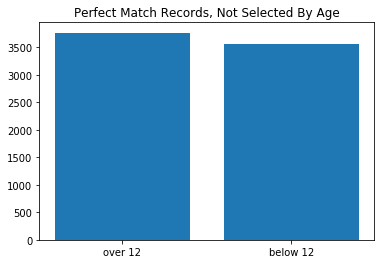

In [137]:
fig, ax = plt.subplots()
plt.bar(np.arange(len(perfect_matches.below_12)), height=perfect_matches.counts.to_list())
plt.xticks(np.arange(len(perfect_matches.below_12)), perfect_matches.below_12.to_list())
plt.title("Perfect Match Records, Not Selected By Age")
plt.show()

In [132]:
np.arange(len(perfect_matches.below_12))

array([0, 1])

**Using distance**

In [139]:
from haversine import haversine, Unit

In [140]:
final_df['dist'] = final_df.apply(lambda row: haversine((row.CENSUS_X, row.CENSUS_Y), (row.LONG, row.LAT), unit=Unit.METERS), axis=1)

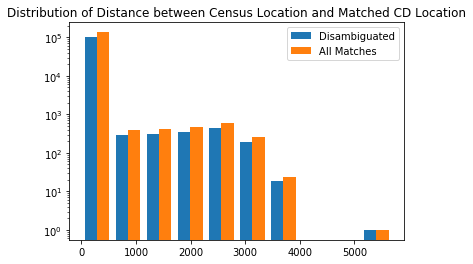

In [67]:
import math
plt.hist([final_df[(final_df.selected == 1)].dist.values, final_df.dist.values], log = True, label = ['Disambiguated', 'All Matches'])
plt.legend()
plt.title('Distribution of Distance between Census Location and Matched CD Location')
plt.show()

In [ ]:
# how does distance differ by ED

In [195]:
# how does distance differ by graph
graph_dist = final_df.groupby("graph_ID").agg({'dist': ['mean', 'count']})
graph_dist.columns = graph_dist.columns.get_level_values(1)

## EDA
### Graphs

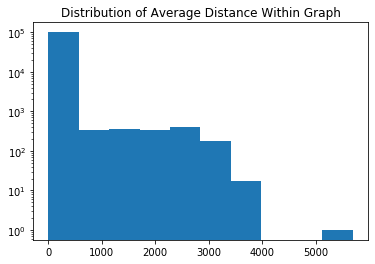

In [201]:
ax, fig = plt.subplots()
plt.hist(graph_dist['mean'].values, log=True)
plt.title("Distribution of Average Distance Within Graph")
plt.show()

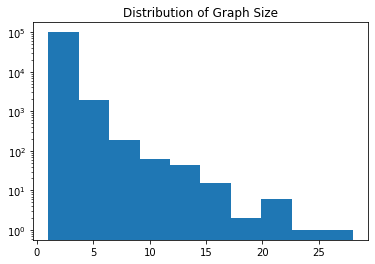

In [202]:
ax, fig = plt.subplots()
plt.hist(graph_dist['count'].values, log=True)
plt.title("Distribution of Graph Size")
plt.show()

In [211]:
# which records are far away
final_df[final_df.dist > 5000]

,Unnamed: 0,CD_ID,CENSUS_ID,anchor,confidence_score_x,in_cluster,spatial_weight,graph_ID,selected,CENSUS_X,CENSUS_Y,CD_FIRST_NAME,CD_LAST_NAME,MATCH_ADDR,CD_OCCUPATION,num_matches,CENSUS_NAMEFRSCLEAN,CENSUS_NAMELASTB,CENSUS_MATCH_ADDR,CENSUS_AGE,CENSUS_OCCLABELB,WARD_NUM,CENSUS_ENUMDIST,CENSUS_SEGMENT_ID,CD_BLOCK_NUM,census_occupation_listed,jaro_winkler_aggr_score,confidence_score_y,LONG,LAT,age_score,census_count,cd_add_cln,cen_add_cln,dist
138214,138214,CD_148209,CENSUS_1116343,0.0,0.95,NaN,1.95,102160.0,1.0,-73.983779,40.744217,George,Gould,"2529 FOURTH AVE, New York, NY",clerk,1,GEORGE,GOLDEY,"421 4TH AVE, NYC-Manhattan, NY",26,BOILER MAKER,12,653,2654,3666,1,0.904,0.95,-73.935834,40.809072,1,1,2529 FOURTH AVE,421 4TH AVE,5691.505222


We can see that the graphs of larger sizes tend to have lower average distances. This suggests that the large distances might be a result of few matches to those records.

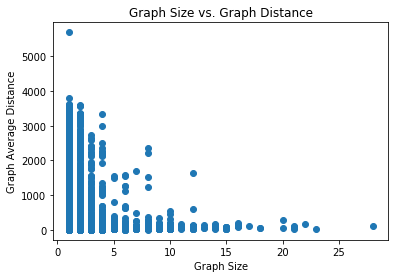

In [210]:
ax, fig = plt.subplots()
plt.scatter(graph_dist['count'].to_list(), graph_dist['mean'].to_list())
plt.xlabel("Graph Size")
plt.ylabel("Graph Average Distance")
plt.title("Graph Size vs. Graph Distance")
plt.show()

### Average confidence score of selected matches

In [54]:
sum(final_df.loc[final_df.selected == 1, :].confidence_score.values) / len(final_df.loc[final_df.selected == 1, :])

0.9558351120083621

In [55]:
sum(final_df.confidence_score.values) / len(final_df)

0.9215124202484423